In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install arff

  Preparing metadata (setup.py) ... done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4950 sha256=4f73f3ab9083b6325a6a637f6d720a5f7c274048e88016b13e30231828c39755
  Stored in directory: /root/.cache/pip/wheels/0c/39/12/4d8ff491018bce2dd9cc6034298f27399c7f4fd4063187f7be
Successfully built arff


In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm, tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Data reading & preprocessing

In [4]:
solvent_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'solvent')
solvent_data.set_index('solvent_name', inplace = True)
solvent_columns = list(solvent_data.columns)

In [5]:
nucleophile_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'nucleophiles')
nucleophile_data.set_index('nucleophile_name', inplace = True)
nucleophile_columns = list(nucleophile_data.columns)

In [6]:
raw_catalyst_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'full_catalyst')
raw_catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)

r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')

catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.set_index('catalyst_name', inplace = True)
catalyst_columns = list(catalyst_data.columns)

In [7]:
raw_catalyst_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'full_catalyst')
raw_catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)

#Taking care of catalyst R/S
r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')
    #print(r_catalyst_data.iloc[i, 1])
#r_catalyst_data.drop(17, inplace = True)

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')
    #print(s_catalyst_data.iloc[i, 1])

catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)
catalyst_data.set_index('catalyst_name', inplace = True)

catalyst_columns = list(catalyst_data.columns)

# catalyst_data

In [8]:
iminium_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/material_project/data/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'iminiums')
iminium_data.rename(columns = {'imine': 'iminium_name', 'electronic energy difference (kcal/mol) ': 'electronic energy difference (kcal/mol)'}, inplace = True)
#removed space at the end of electronic energy
iminium_data.set_index('iminium_name', inplace = True)
iminium_data.drop(labels = ['Unnamed: 1'], axis = 1, inplace = True)
for i in range(1, 181):
    z_iminium_name = '(Z)-Iminium ' + str(i)
    e_iminium_name = '(E)-Iminium ' + str(i)
    iminium_data.loc[z_iminium_name, 'electronic energy difference (kcal/mol)'] = iminium_data.loc[e_iminium_name, 'electronic energy difference (kcal/mol)']
iminium_columns = list(iminium_data.columns)

In [9]:
class Reaction():

    def __init__(self, name, entry, catalyst, nucleophile, substrate, solvent, iminium_type, iminium, majorenantiomer, minorenantiomer, ee, G):
        self.name = name
        self.entry = entry
        self.catalyst = catalyst
        self.nucleophile = nucleophile
        self.substrate = substrate
        self.solvent = solvent
        self.iminium_type = iminium_type
        self.iminium = iminium
        self.majorenantiomer = majorenantiomer
        self.minorenantiomer = minorenantiomer
        self.ee = ee
        self.G = G

        self.solvent_properties = dict()
        for column in solvent_columns:
            self.solvent_properties[column] = solvent_data.loc[solvent, column]

        self.catalyst_properties = dict()
        for column in catalyst_columns:
            self.catalyst_properties[column] = catalyst_data.loc[catalyst, column]

        self.nucleophile_properties = dict()
        for column in nucleophile_columns:
            self.nucleophile_properties[column] = nucleophile_data.loc[nucleophile, column]

        self.e_iminium = '(E)-' + str(iminium)
        self.z_iminium = '(Z)-' + str(iminium)

        self.e_iminium_properties = dict()
        self.z_iminium_properties = dict()
        for column in iminium_columns:
            self.e_iminium_properties[column] = iminium_data.loc[self.e_iminium, column]
            self.z_iminium_properties[column] = iminium_data.loc[self.z_iminium, column]



    def __repr__(self):
        return "Reaction - {}".format(self.name)
        #iminium stuff

In [10]:
reactions = dict()

def process_data(reaction_number, reaction, iminium_type, sheetname = None):
    reaction_file = '/content/drive/My Drive/Colab Notebooks/material_project/data/reaction information/' + str(reaction_number) + ' ' + reaction + '.xlsx'
    if sheetname == None:
        data = pd.read_excel(reaction_file)
    else:
        data = pd.read_excel(reaction_file, sheet_name = sheetname)

    data.set_index('entry', inplace = True)

    entries = len(data)
    for entry in range(1, entries + 1):
        if sheetname == None:
            reaction_name = reaction + ' ' + str(entry)
        else:
            reaction_name = reaction + ' ' + sheetname + ' ' + str(entry)


        reactions[reaction_name] = Reaction(reaction_name,
                                            entry,
                                            data.loc[entry, 'Catalyst'],
                                            data.loc[entry, 'Nucleophile'],
                                            data.loc[entry, 'Substrate'],
                                            data.loc[entry, 'Solvent'],
                                            iminium_type,
                                            data.loc[entry, 'Iminium'],
                                            data.loc[entry, 'Major Enantiomer'],
                                            data.loc[entry, 'Minor Enantiomer'],
                                            data.loc[entry, 'ee'],
                                            data.loc[entry, 'ΔΔG‡'])



In [11]:
process_data(1, 'Addition of Alcohols', 'E', 'Scope')
process_data(2, 'Addition of thiols', 'E', 'Catalyst & solvent screening da')
process_data(2, 'Addition of thiols', 'E', 'Effect of catalyst loading')
process_data(2, 'Addition of thiols', 'E', 'Imine scope')
process_data(2, 'Addition of thiols', 'E', 'Thiol scope')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Catalyst screening data')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Scope')
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Optimization of catalyst and re")
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Imine scope")
process_data(5, 'Addition of diazoacetamides', 'E', 'Catalyst screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Solvent screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Substrate(s) scope')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Catalyst screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Solvent screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Imine scope')
process_data(7, 'Peroxidation of imines', 'E', 'Catalyst screening data')
process_data(7, 'Peroxidation of imines', 'E', 'Solvent screening data')
#process_data(7, 'Peroxidation of imines', 'E', 'Substrate(s) scope')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Catalyst screening and reaction')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Scope')
process_data(9, 'Transfer Hydrogenation of Enamides', 'E', 'Scope')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Catalyst screening data')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Imine scope')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Catalyst screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Solvent screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Imine scope')
#process_data(12, 'Reductive amination of N-aryl imines (Macmillan)', 'Z', 'Reaction optimization')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Imine scope')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Catalyst screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Benzothiazoline screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Imine scope')
#process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Catalyst screening data')
#process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Imine scope')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 1 benzothiazoline')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 2 dihydropyridine')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Catalyst screening data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Solvent data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Imine scope')
#process_data(18, 'Addition of enecarbamates to benzoyl imines')
#process_data(19, 'Hydrogenation of fluorinated alkynyl ketimines')
#process_data(20, 'Addition of thiols to imines (Denmark)')

In [12]:
print(len(reactions))

342


In [13]:
catalyst = pd.DataFrame(columns = ['Reaction'] + catalyst_columns)
catalyst.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in catalyst_columns:
        catalyst.loc[reaction, column] = reactions[reaction].catalyst_properties[column]

#first column is numerical

In [14]:
nucleophile = pd.DataFrame(columns = ['Reaction'] + nucleophile_columns)
nucleophile.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in nucleophile_columns:
        nucleophile.loc[reaction, column] = reactions[reaction].nucleophile_properties[column]

#first column is numerical

In [15]:
solvent = pd.DataFrame(columns = ['Reaction'] + solvent_columns)
solvent.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in solvent_columns:
        solvent.loc[reaction, column] = reactions[reaction].solvent_properties[column]

#first column is numerical

In [16]:
iminium = pd.DataFrame(columns = ['Reaction', "iminium_type"] + iminium_columns)
iminium.set_index('Reaction', inplace = True)

for reaction in reactions:
    if reactions[reaction].iminium_type == 'E':
        iminium.loc[reaction, "iminium_type"] = 'E'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].e_iminium_properties[column]
    elif reactions[reaction].iminium_type == 'Z':
        iminium.loc[reaction, "iminium_type"] = 'Z'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].z_iminium_properties[column]



In [17]:
ee = pd.DataFrame(columns = ['Reaction', 'ee'])
ee.set_index('Reaction', inplace = True)

for reaction in reactions:
    ee.loc[reaction, 'ee'] = reactions[reaction].ee

In [18]:
Y = pd.DataFrame(columns = ['Reaction', 'ΔΔG‡'])
Y.set_index('Reaction', inplace = True)

for reaction in reactions:
    Y.loc[reaction, 'ΔΔG‡'] = reactions[reaction].G


In [19]:
print(catalyst.shape, nucleophile.shape, solvent.shape, iminium.shape, ee.shape)

(342, 85) (342, 15) (342, 160) (342, 22) (342, 1)


In [20]:
X_iminium = pd.concat([catalyst.drop(['Ar group'], axis = 1),
               nucleophile.drop(['nucleophile'], axis = 1),
               solvent.drop(['solvent'], axis = 1),
               iminium.drop(['iminium_type'], axis = 1)], axis = 1)
X_iminium.shape

(342, 278)

In [21]:
#no iminium features
X_no_iminium = pd.concat([catalyst.drop(['Ar group'], axis = 1),
               nucleophile.drop(['nucleophile'], axis = 1),
               solvent.drop(['solvent'], axis = 1)], axis = 1)
X_no_iminium.shape

(342, 257)

In [22]:
X_no_nucleophile = pd.concat([catalyst.drop(['Ar group'], axis = 1),
                   solvent.drop(['solvent'], axis = 1)], axis = 1)
X_no_nucleophile.shape

(342, 243)

In [23]:
for reaction in reactions:
    if iminium.loc[reaction, 'iminium_type'] == 'Z':
        Y.loc[reaction, 'ΔΔG‡'] = Y.loc[reaction, 'ΔΔG‡'] * (-1)

In [24]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.8.1.
The scikit-learn version is 1.2.2.


In [25]:
!pip install eli5
!conda install -c conda-forge eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=546854997934c5069df1fcfe6f3575371e2f9a676964d5537c1afd5ea028e1d6
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
/bin/bash: line 1: conda: command not found


In [26]:
# -*- coding: utf-8 -*-

from functools import partial
from typing import List

import numpy as np
from sklearn.model_selection import check_cv
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.utils import check_array, check_random_state
from sklearn.base import (
    BaseEstimator,
    MetaEstimatorMixin,
    clone,
    is_classifier
)
from sklearn.metrics import check_scoring

from eli5.permutation_importance import get_score_importances
from eli5.sklearn.utils import pandas_available

if pandas_available:
    import pandas as pd

CAVEATS_CV_NONE = """
Feature importances are computed on the same data as used for training,
i.e. feature importances don't reflect importance of features for
generalization.
"""

CAVEATS_CV = """
Feature importances are not computed for the final estimator;
they are computed for a sequence of estimators trained and evaluated
on train/test splits. So they tell you about importances of features
for generalization, but not feature importances of a particular trained model.
"""

CAVEATS_PREFIT = """
If feature importances are computed on the same data as used for training,
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.
"""


class PermutationImportance(BaseEstimator, MetaEstimatorMixin):
    print("AAAAAAAAAAA1111")
    """Meta-estimator which computes ``feature_importances_`` attribute
    based on permutation importance (also known as mean score decrease).

    :class:`~PermutationImportance` instance can be used instead of
    its wrapped estimator, as it exposes all estimator's common methods like
    ``predict``.

    There are 3 main modes of operation:

    1. cv="prefit" (pre-fit estimator is passed). You can call
       PermutationImportance.fit either with training data, or
       with a held-out dataset (in the latter case ``feature_importances_``
       would be importances of features for generalization). After the fitting
       ``feature_importances_`` attribute becomes available, but the estimator
       itself is not fit again. When cv="prefit",
       :meth:`~PermutationImportance.fit` must be called
       directly, and :class:`~PermutationImportance` cannot be used with
       ``cross_val_score``, ``GridSearchCV`` and similar utilities that clone
       the estimator.
    2. cv=None. In this case :meth:`~PermutationImportance.fit` method fits
       the estimator and computes feature importances on the same data, i.e.
       feature importances don't reflect importance of features for
       generalization.
    3. all other ``cv`` values. :meth:`~PermutationImportance.fit` method
       fits the estimator, but instead of computing feature importances for
       the concrete estimator which is fit, importances are computed for
       a sequence of estimators trained and evaluated on train/test splits
       according to ``cv``, and then averaged. This is more resource-intensive
       (estimators are fit multiple times), and importances are not computed
       for the final estimator, but ``feature_importances_`` show importances
       of features for generalization.

    Mode (1) is most useful for inspecting an existing estimator; modes
    (2) and (3) can be also used for feature selection, e.g. together with
    sklearn's SelectFromModel or RFE.

    Currently :class:`~PermutationImportance` works with dense data.

    Parameters
    ----------
    estimator : object
        The base estimator. This can be both a fitted
        (if ``prefit`` is set to True) or a non-fitted estimator.

    scoring : string, callable or None, default=None
        Scoring function to use for computing feature importances.
        A string with scoring name (see scikit-learn `docs`_) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
        If ``None``, the ``score`` method of the estimator is used.

        .. _docs: https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

    n_iter : int, default 5
        Number of random shuffle iterations. Decrease to improve speed,
        increase to get more precise estimates.

    random_state : integer or numpy.random.RandomState, optional
        random state

    cv : int, cross-validation generator, iterable or "prefit"
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

            - None, to disable cross-validation and compute feature importances
              on the same data as used for training.
            - integer, to specify the number of folds.
            - An object to be used as a cross-validation generator.
            - An iterable yielding train/test splits.
            - "prefit" string constant (default).

        If "prefit" is passed, it is assumed that ``estimator`` has been
        fitted already and all data is used for computing feature importances.

    refit : bool
        Whether to fit the estimator on the whole data if cross-validation
        is used (default is True).

    Attributes
    ----------
    feature_importances_ : array
        Feature importances, computed as mean decrease of the score when
        a feature is permuted (i.e. becomes noise).

    feature_importances_std_ : array
        Standard deviations of feature importances.

    results_ : list of arrays
        A list of score decreases for all experiments.

    scores_ : array of float
        A list of base scores for all experiments (with no features permuted).

    estimator_ : an estimator
        The base estimator from which the :class:`~PermutationImportance`
        instance  is built. This is stored only when a non-fitted estimator
        is passed to the :class:`~PermutationImportance`, i.e when ``cv`` is
        not "prefit".

    rng_ : numpy.random.RandomState
        random state
    """
    def __init__(self, estimator, scoring='neg_mean_squared_error', n_iter=1, random_state=None,
                 cv='prefit', refit=True):
        # type: (...) -> None
        if isinstance(cv, str) and cv != "prefit":
            raise ValueError("Invalid cv value: {!r}".format(cv))
        self.refit = refit
        self.estimator = estimator
        self.scoring = scoring
        self.n_iter = n_iter
        self.random_state = random_state
        self.cv = cv
        self.rng_ = check_random_state(random_state)

    def _wrap_scorer(self, base_scorer, pd_columns):
        def pd_scorer(model, X, y):
            X = pd.DataFrame(X, columns=pd_columns)
            return base_scorer(model, X, y)
        return pd_scorer

    def fit(self, X, y, groups=None, **fit_params):
        # type: (...) -> PermutationImportance
        """Compute ``feature_importances_`` attribute and optionally
        fit the base estimator.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training input samples.

        y : array-like, shape (n_samples,)
            The target values (integers that correspond to classes in
            classification, real numbers in regression).

        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.

        **fit_params : Other estimator specific parameters

        Returns
        -------
        self : object
            Returns self.
        """
        self.scorer_ = check_scoring(self.estimator, scoring=self.scoring)

        if pandas_available and isinstance(X, pd.DataFrame):
            self.scorer_ = self._wrap_scorer(self.scorer_, X.columns)

        if self.cv != "prefit" and self.refit:
            self.estimator_ = clone(self.estimator)
            self.estimator_.fit(X, y, **fit_params)

        X = check_array(X, force_all_finite='allow-nan')

        if self.cv not in (None, "prefit"):
            si = self._cv_scores_importances(X, y, groups=groups, **fit_params)
        else:
            si = self._non_cv_scores_importances(X, y)
        scores, results = si
        self.scores_ = np.array(scores)
        self.results_ = results
        self.feature_importances_ = np.mean(results, axis=0)
        # print("AAAAAAAAAAA")
        # print(len(results))
        self.feature_importances_std_ = np.std(results, axis=0)
        return self


    def _cv_scores_importances(self, X, y, groups=None, **fit_params):
        # print("1")
        assert self.cv is not None
        cv = check_cv(self.cv, y, is_classifier(self.estimator))
        feature_importances = []  # type: List
        base_scores = []  # type: List[float]
        weights = fit_params.pop('sample_weight', None)
        fold_fit_params = fit_params.copy()
        for train, test in cv.split(X, y, groups):
            if weights is not None:
                fold_fit_params['sample_weight'] = weights[train]
            est = clone(self.estimator).fit(X[train], y[train], **fold_fit_params)
            score_func = partial(self.scorer_, est)
            _base_score, _importances = self._get_score_importances(
                score_func, X[test], y[test])
            base_scores.extend([_base_score] * len(_importances))
            feature_importances.extend(_importances)
        return base_scores, feature_importances

    def _non_cv_scores_importances(self, X, y):
        # print("2")
        score_func = partial(self.scorer_, self.wrapped_estimator_)
        base_score, importances = self._get_score_importances(score_func, X, y)
        return [base_score] * len(importances), importances

    def _get_score_importances(self, score_func, X, y):
        # print("3")
        # print(self.scoring)
        # print(self.n_iter)
        return get_score_importances(score_func, X, y, n_iter=self.n_iter,
                                     random_state=self.rng_)

    @property
    def caveats_(self):
        # type: () -> str
        if self.cv == 'prefit':
            return CAVEATS_PREFIT
        elif self.cv is None:
            return CAVEATS_CV_NONE
        return CAVEATS_CV

    # ============= Exposed methods of a wrapped estimator:

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def score(self, X, y=None, *args, **kwargs):
        return self.wrapped_estimator_.score(X, y, *args, **kwargs)

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def predict(self, X):
        return self.wrapped_estimator_.predict(X)

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def predict_proba(self, X):
        return self.wrapped_estimator_.predict_proba(X)

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def predict_log_proba(self, X):
        return self.wrapped_estimator_.predict_log_proba(X)

    @if_delegate_has_method(delegate='wrapped_estimator_')
    def decision_function(self, X):
        return self.wrapped_estimator_.decision_function(X)

    @property
    def wrapped_estimator_(self):
        if self.cv == "prefit" or not self.refit:
            return self.estimator
        return self.estimator_

    @property
    def _estimator_type(self):
        return self.estimator._estimator_type

    @property
    def classes_(self):
        return self.wrapped_estimator_.classes_


AAAAAAAAAAA1111


Run 100 replications with Monte-carlo cross validation


In [27]:
X = X_iminium

In [28]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.1, random_state = 1)

In [29]:
import os
import pandas as pd
import numpy as np
import sklearn
import random
import heapq
import matplotlib.pyplot as plt


from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal

from scipy.stats import norm
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot


from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import pearsonr
from numpy.random import random


from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [30]:
X.shape

(342, 278)

In [31]:

X_train_train, X_valid, Y_train_train, Y_valid = train_test_split( X_train1,Y_train1, test_size = 0.2, random_state = 100)



X_valid=X_valid.to_numpy()
Y_valid=Y_valid.to_numpy()
X_train_train=X_train_train.to_numpy()
Y_train_train=Y_train_train.to_numpy()

Bayesian optimization for hyperparameter tuning

In [32]:

validation_replication=1
result_valid=np.zeros(validation_replication)
result_valid=np.reshape(result_valid,(1,validation_replication))








def objective(x1):

    # Constraints for each hyperparameter
    # All hyperparameters are positive integers.
    # Minimum of "regularization parameter" : 0.1.

    a1 = float(x1)


    if a1<0.1:
        a1=0.1


# Performance evaluation for  validation set
    for j in range(0,1):
        # Fit the model with training data and check the Mean Absolute Percentage Error (MSE) of validation data
        reg_m = make_pipeline(StandardScaler(), SVR(C=a1, epsilon=0.2))
        reg_m.fit(X_train_train, Y_train_train.ravel());

        predicted_y_m = reg_m.predict(X_valid);
        prediction=np.reshape(predicted_y_m,(predicted_y_m.shape[0],1))
        result_valid[0,j] =(mean_squared_error(Y_valid, prediction))
    # Since Bayesian Optimization is maximization problem, we used reciprocal as output.
    return (1/np.mean(result_valid))

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    #with catch_warnings():
        # ignore generated warnings if the distribution is thin at a given point
        #simplefilter("ignore")
        return model.predict(X, return_std=True)

# We used Expected Improvement as our acquisition function.
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    #mu = mu[:, 0]
    # calculate the Expected improvement
    probs = (mu - best) * norm.cdf((mu - best) / (std + 1E-9)) + (std + 1E-9) * norm.pdf((mu - best) / (std + 1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    np.random.seed(i*100+h*100+100*i1)
    # random search, generate random samples
    X1samples = 10 * random((100,1))

    # calculate the acquisition function for each sample
    Xsamples = X1samples
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix,]



X1 = [3]
X1 = asarray(X1)


y = asarray([objective(X1)])
X = X1
X = X.reshape(len(X1),1)
y = y.reshape(len(y),1)
h=0




# Starting from given 20 points
for i1 in range(0,20):
    np.random.seed(i1*100+i*100)
    X1 = 10* random(1)

    ysample = asarray([objective(X1)])
    # Xsample = np.concatenate((X1),axis=0)
    Xsample = X1
    Xsample = Xsample.reshape(len(X1),1)
    ysample = ysample.reshape(len(ysample),1)

    X = vstack((X,Xsample))
    y = vstack((y,ysample))
# define the surrogate model
model = GaussianProcessRegressor()
model.fit(X, y)



# Sample new points (hyperparameters) with Bayesian Optimization.
# It sequentialy samples 100 points based on the optimization.
for h in range(100):
    print(h)
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    x = asarray(x)
    # sample the point
    actual = objective(x[0])
    est, _ = surrogate(model,[x])
    actual = asarray(actual)
    #print(' f()=%3f, actual=%.3f' % (est, actual))
    # add the data to the dataset
    X = vstack((X,[x]))
    y = vstack((y,[[actual]]))
    # update the model
    model.fit(X, y)
    # best result
    ix = argmax(y)
    print("Current")
    print(x[0],1/est,1/actual)

#Provide Best hyperparameters settings based on Bayesian Optimization.
print("Best")
print((X[ix, 0],y[ix],1/y[ix]),ix)



a1=float(X[ix,0])

if a1<0.1:
    a1=0.1
print(a1)



<ipython-input-32-f1c7271ac432>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a1 = float(x1)
<ipython-input-32-f1c7271ac432>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a1 = float(x1)
<ipython-input-32-f1c7271ac432>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a1 = float(x1)
<ipython-input-32-f1c7271ac432>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single elem

0
Current
8.92298864768766 [0.17284688] 0.17905982194075443
1
Current
9.97156124908612 [0.1783531] 0.1787995657786856
2
Current
9.982396155546109 [0.17879447] 0.17878900964084946
3
Current
8.68402591522614 [0.17888711] 0.17918242804720788
4
Current
0.5108090789118946 [0.4433657] 0.4435976267305087
5
Current
9.430315539078403 [0.17885244] 0.1789286290876942
6
Current
0.32061226911335616 [0.74875163] 0.7608694084126545
7
Current
0.9889884409049121 [0.40331576] 0.2764325249852989
8
Current
3.9384184561646416 [0.11906406] 0.19471821700539949
9
Current
3.222554765392489 [0.19036926] 0.20023040841736053
10
Current
9.972751643376302 [0.17879435] 0.17878164157433044
11
Current
0.4617290721566225 [0.48821506] 0.49380991454648787
12
Current
3.3488592016866536 [0.19868961] 0.19838074993282775
13
Current
7.307908179213981 [0.18216425] 0.18217237464750044
14
Current
8.090267093236832 [0.18007923] 0.18001831052307732
15
Current
6.11434656770724 [0.18402895] 0.1837185889323178
16
Current
9.3131995260

Run 100 replications with Monte-carlo cross validation
Calculate mean & standard deviation of MSE and R^2
Permutation importance analysis

In [33]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
result_important=np.zeros((278,100))
def run_svr(iterations, value):
    scores = pd.DataFrame(columns = ['iteration', 'MSE', 'test r^2', 'train r^2', 'total r^2'])
    #scores.set_index('iteration', inplace = True)
    for i in range(iterations):
        print(i)
        a=10*i
        # parameter=10*value
        forest = make_pipeline(StandardScaler(), SVR(C=9.99, epsilon=0.2))
        X_train, X_test, Y_train, Y_test = train_test_split(X_train1, Y_train1, test_size = 0.2, random_state = a)

        svc=forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())



        #evaluating performance
        Y_pred = forest.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

        results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
        results.set_index('Reaction', inplace = True)
        results.columns = ['Actual', 'Predicted']

        Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
        train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
        train_results.set_index('Reaction', inplace = True)
        train_results.columns = ['Actual', 'Predicted']

        all_results = pd.concat([train_results, results])

        scores = scores.append({'iteration': str(i+1),
                    'MSE': mean_squared_error(Y_test, Y_pred),
                    'test r^2': r2_score(Y_test, Y_pred),
                    'train r^2': r2_score(train_results['Actual'], train_results['Predicted']),
                    'total r^2': r2_score(all_results['Actual'], all_results['Predicted'])}, ignore_index = True)


        perm = PermutationImportance(svc).fit(X_train, Y_train, scoring='neg_mean_squared_error')

        if i == 0:
            total_features_mean = (perm.feature_importances_)
        else:
            total_features_mean = total_features_mean+(perm.feature_importances_)
        result_important[:,i]=perm.feature_importances_
        if i == 0:
            total_features_std = perm.feature_importances_std_
        else:
            total_features_std = total_features_std+perm.feature_importances_std_




        if i==0:
          print(Y_test.shape)
          plt.figure(figsize=(8,8))
          plt.scatter(pd.concat([Y_test]), Y_pred, c='crimson')
          # plt.yscale('log')
          # plt.xscale('log')
          a111=np.asarray(pd.concat([Y_test]))
          p1 = max(max(Y_pred), max(a111))
          p2 = min(min(Y_pred), min(a111))
          plt.plot([p1, p2], [p1, p2], 'b-')
          plt.title("Scatter Plot of Activation Energy", fontsize=18)
          plt.xlabel('True Values', fontsize=15)
          plt.ylabel('Predictions', fontsize=15)
          plt.axis('equal')
          plt.show()


    return scores,  total_features_mean ,  total_features_std

In [34]:
import warnings
warnings.filterwarnings("ignore")


+

Parameter
0.1
0
(62, 1)


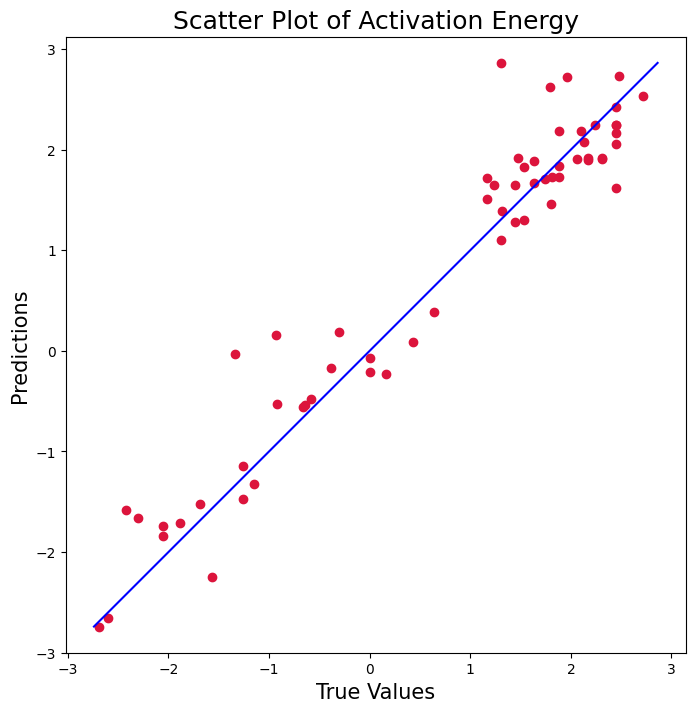

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
   iteration       MSE  test r^2  train r^2  total r^2
0          1  0.198069  0.924967   0.974740   0.965633
1          2  0.214970  0.931348   0.975647   0.966030
2          3  0.162218  0.941774   0.974021   0.967933
3          4  0.170547  0.933487   0.974874   0.967490
4          5  0.141982  0.951846   0.973690   0.969194
..       ...       ...       ...        ...        ...
95        96  0.111361  0.965858   0.970046   0.969173
96        97  0.206632  0.939342   0.975829   0.967438
97        98  0.181170  0.936089   0.974766   0.967107
98        99  0.156090  0.945329   0.974727   0.968976
99       100  0.135196  0.940883   0.972609   0.967634

[100 rows x 5 columns]
iteration    1.234568e+189
M

In [35]:
for i in range(1,2):
  print("Parameter")
  print(0.1*i)
  results_svr, mean, std = run_svr(100,i)
  print(results_svr)
  print(results_svr.mean())
  print(results_svr.std())
  # print(mean)
  # print(std)

In [36]:
print(np.argsort((mean)))

[252 225 230 181 145 240 224 200 206 216 219 210 222 129 217 177 149 226
 218 104 213 195 188 194  36 223 221 256 178 220 128 147  18 204 148 140
 237  15  39 105  37 127  66 165  30  74  54   6 232 139  82  51 164 245
 201 253 166 106  19 103  50  60 255  63  79 111  25 243 180 199  75 246
  61 182  42 158  73 192  49  38  20 110 197  64  67 247 229 175 101  26
 155  13 231  80 179  16  40  65 215 186  99  28 208  76 207 196 205  72
 150 236 133  62 142 132  41 137  29 239  77   4  12 167 190 198 141  52
 209 251  27  17 100  43 122  98  24 143 126   3  53 184  34 242   5   0
 161 118 176  81 144 112 130 214 162  59  78 125  11  68  83  44  58  48
 202 191 249  57 115 159  14 102 174  31   7 235 116 248  33 168   2 254
   9 131 114  35  56   1  10 108  47 113 109  45  23 189  55  70  69 211
  32 173 163 156   8 124 123  21 172 121 136 203 117  71 135 187 193  46
 119 157  22 185 227 183 107 228 134 152 146 169 250 233 120 160 154 171
 170 241 138 151 234 238 212 153 270 244  85 268 25

In [37]:
print(np.mean(result_important,axis=1)[97])
print(np.mean(result_important,axis=1)[275])
print(np.mean(result_important,axis=1)[261])
print(np.mean(result_important,axis=1)[96])
print(np.mean(result_important,axis=1)[259])
print(np.mean(result_important,axis=1)[269])
print(np.mean(result_important,axis=1)[263])
print(np.mean(result_important,axis=1)[264])


0.05826572540857427
0.0550413316366605
0.03917692840287
0.03235718435238106
0.028120573663425085
0.024640809130065673
0.017965882454288196
0.017469024476938707


In [38]:
print(np.std(result_important,axis=1)[97])
print(np.std(result_important,axis=1)[275])
print(np.std(result_important,axis=1)[261])
print(np.std(result_important,axis=1)[96])
print(np.std(result_important,axis=1)[259])
print(np.std(result_important,axis=1)[269])
print(np.std(result_important,axis=1)[263])
print(np.std(result_important,axis=1)[264])


0.010199342179091544
0.01166588553656821
0.008289817116399513
0.0069213124453324365
0.007603917351178742
0.005958769710876384
0.0064018254030019685
0.0055481032843835735


Partial dependence plot

In [39]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/material_project/code/original/chem_brandeis/IEEE_BIBM_SUBMIT/revision')
# X_train.to_excel('xtrain_pdp.xlsx',  index=False)

In [40]:
X_train_pdp = pd.read_excel('xtrain_pdp_name.xlsx')

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train1, Y_train1, test_size = 0.2, random_state = 1)
forest = make_pipeline(StandardScaler(), SVR(C=9.99, epsilon=0.2))
svc=forest.fit(X_train_pdp, Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())

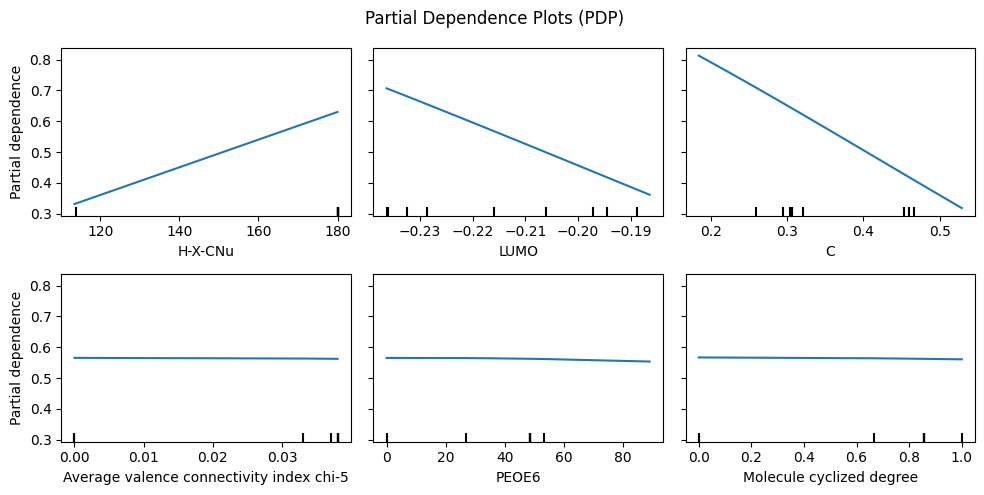

In [42]:
from sklearn.inspection import PartialDependenceDisplay
pdp_features=[97,275,261,145, 240, 224 ]
fig, ax = plt.subplots(2,3,figsize=(10,5))
# ax.set_title("Decision Tree")
fig.suptitle('Partial Dependence Plots (PDP)')
PartialDependenceDisplay.from_estimator(svc, X_train_pdp, pdp_features,ax=ax)
fig.tight_layout()

In [43]:
X = X_iminium

In [44]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.1, random_state = 1)

In [45]:
X=X_no_iminium

Analysis without Imine's features

In [46]:
os.chdir('/content/drive/My Drive/Colab Notebooks/material_project/code/original/chem_brandeis/IEEE_BIBM')
X_train2 = pd.read_excel('X_train2.xlsx', index_col=0)

In [47]:
print(X_train2.shape)
print(X_no_iminium.shape)

(307, 257)
(342, 257)


In [48]:
import os
import pandas as pd
import numpy as np
import sklearn
import random
import heapq
import matplotlib.pyplot as plt


from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal

from scipy.stats import norm
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot


from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import pearsonr
from numpy.random import random


from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Bayesian optimization for hyperparameter tuning


In [49]:

X_train_train, X_valid, Y_train_train, Y_valid = train_test_split( X_train2,Y_train1, test_size = 0.2, random_state = 100)



X_valid=X_valid.to_numpy()
Y_valid=Y_valid.to_numpy()
X_train_train=X_train_train.to_numpy()
Y_train_train=Y_train_train.to_numpy()

In [50]:

validation_replication=1
result_valid=np.zeros(validation_replication)
result_valid=np.reshape(result_valid,(1,validation_replication))








def objective(x1):

    # Constraints for each hyperparameter
    # All hyperparameters are positive integers.
    # Minimum of "regularization parameter" : 0.1.

    a1 = float(x1)


    if a1<0.1:
        a1=0.1


# Performance evaluation for  validation set
    for j in range(0,1):
        # Fit the model with training data and check the Mean Absolute Percentage Error (MSE) of validation data
        reg_m = make_pipeline(StandardScaler(), SVR(C=a1, epsilon=0.2))
        reg_m.fit(X_train_train, Y_train_train.ravel());

        predicted_y_m = reg_m.predict(X_valid);
        prediction=np.reshape(predicted_y_m,(predicted_y_m.shape[0],1))
        result_valid[0,j] =(mean_squared_error(Y_valid, prediction))
    # Since Bayesian Optimization is maximization problem, we used reciprocal as output.
    return (1/np.mean(result_valid))

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    #with catch_warnings():
        # ignore generated warnings if the distribution is thin at a given point
        #simplefilter("ignore")
        return model.predict(X, return_std=True)

# We used Expected Improvement as our acquisition function.
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    #mu = mu[:, 0]
    # calculate the Expected improvement
    probs = (mu - best) * norm.cdf((mu - best) / (std + 1E-9)) + (std + 1E-9) * norm.pdf((mu - best) / (std + 1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    np.random.seed(i*100+h*100+100*i1)
    # random search, generate random samples
    X1samples = 10 * random((100,1))

    # calculate the acquisition function for each sample
    Xsamples = X1samples
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix,]



X1 = [3]
X1 = asarray(X1)


y = asarray([objective(X1)])
X = X1
X = X.reshape(len(X1),1)
y = y.reshape(len(y),1)
h=0




# Starting from given 20 points
for i1 in range(0,20):
    np.random.seed(i1*100+i*100)
    X1 = 10* random(1)

    ysample = asarray([objective(X1)])
    # Xsample = np.concatenate((X1),axis=0)
    Xsample = X1
    Xsample = Xsample.reshape(len(X1),1)
    ysample = ysample.reshape(len(ysample),1)

    X = vstack((X,Xsample))
    y = vstack((y,ysample))
# define the surrogate model
model = GaussianProcessRegressor()
model.fit(X, y)



# Sample new points (hyperparameters) with Bayesian Optimization.
# It sequentialy samples 100 points based on the optimization.
for h in range(100):
    print(h)
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    x = asarray(x)
    # sample the point
    actual = objective(x[0])
    est, _ = surrogate(model,[x])
    actual = asarray(actual)
    #print(' f()=%3f, actual=%.3f' % (est, actual))
    # add the data to the dataset
    X = vstack((X,[x]))
    y = vstack((y,[[actual]]))
    # update the model
    model.fit(X, y)
    # best result
    ix = argmax(y)
    print("Current")
    print(x[0],1/est,1/actual)

#Provide Best hyperparameters settings based on Bayesian Optimization.
print("Best")
print((X[ix, 0],y[ix],1/y[ix]),ix)



a1=float(X[ix,0])

if a1<0.1:
    a1=0.1
print(a1)



0
Current
8.814056557487058 [0.13087268] 0.22881958434541547
1
Current
8.4723279599862 [0.2102541] 0.22950736189740645
2
Current
9.31379414084753 [0.22318431] 0.2275521807148966
3
Current
9.746188690065619 [0.22572553] 0.22655718084939017
4
Current
5.495037049928564 [0.23771493] 0.23767752195338465
5
Current
9.978697940607827 [0.22558235] 0.22597518827236107
6
Current
0.812411294364831 [0.74089043] 0.7407957346615477
7
Current
9.572485188219652 [0.22693252] 0.22698328810379856
8
Current
9.978481643284127 [0.22597509] 0.22596501463113192
9
Current
8.459939742093642 [0.22952519] 0.2295694779566479
10
Current
5.107935611666639 [0.23860918] 0.2384666230381808
11
Current
9.978623006698141 [0.22596979] 0.22597026620747582
12
Current
8.485480859046284 [0.22950276] 0.22952256441355604
13
Current
6.495429861057857 [0.23209296] 0.23210768331688686
14
Current
4.772054374692861 [0.24275781] 0.24218594177129377
15
Current
6.0958762937404485 [0.23389896] 0.23377162921486902
16
Current
9.992347366071

In [51]:
X_train2.shape

(307, 257)

Run 100 replications with Monte-carlo cross validation Calculate mean & standard deviation of MSE and R^2

In [52]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
result_important=np.zeros((257,100))
def run_svr(iterations, value):
    scores = pd.DataFrame(columns = ['iteration', 'MSE', 'test r^2', 'train r^2', 'total r^2'])
    for i in range(iterations):
        print(i)
        a=10*i
        # parameter=10*value
        forest = make_pipeline(StandardScaler(), SVR(C=9.99, epsilon=0.2))
        X_train, X_test, Y_train, Y_test = train_test_split(X_train2, Y_train1, test_size = 0.2, random_state = a)

        svc=forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())



        #evaluating performance
        Y_pred = forest.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

        results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
        results.set_index('Reaction', inplace = True)
        results.columns = ['Actual', 'Predicted']

        Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
        train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
        train_results.set_index('Reaction', inplace = True)
        train_results.columns = ['Actual', 'Predicted']

        all_results = pd.concat([train_results, results])

        scores = scores.append({'iteration': str(i+1),
                    'MSE': mean_squared_error(Y_test, Y_pred),
                    'test r^2': r2_score(Y_test, Y_pred),
                    'train r^2': r2_score(train_results['Actual'], train_results['Predicted']),
                    'total r^2': r2_score(all_results['Actual'], all_results['Predicted'])}, ignore_index = True)


        perm = PermutationImportance(svc).fit(X_train, Y_train, scoring='neg_mean_squared_error')


        if i == 0:
            total_features_mean = (perm.feature_importances_)
        else:
            total_features_mean = total_features_mean+(perm.feature_importances_)
        result_important[:,i]=perm.feature_importances_
        if i == 0:
            total_features_std = perm.feature_importances_std_
        else:
            total_features_std = total_features_std+perm.feature_importances_std_







    return scores,  total_features_mean ,  total_features_std

In [53]:
for i in range(1,2):
  print("Parameter")
  print(0.1*i)
  results_svr, mean, std = run_svr(100,i)
  print(results_svr)
  print(results_svr.mean())
  print(results_svr.std())
  # print(mean)
  # print(std)

Parameter
0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
   iteration       MSE  test r^2  train r^2  total r^2
0          1  0.261606  0.900897   0.963190   0.951809
1          2  0.211148  0.932569   0.958493   0.952957
2          3  0.182016  0.934667   0.957262   0.953179
3          4  0.222498  0.913226   0.959855   0.951553
4          5  0.147079  0.950118   0.956468   0.955172
..       ...       ...       ...        ...        ...
95        96  0.171070  0.947552   0.958651   0.956233
96        97  0.197891  0.941908   0.959520   0.955827
97        98  0.237141  0.916344   0.962532   0.953388
98        99  0.181658  0.936373   0.961136   0.956375
99       100  0.259754  0.886419   0.961805   0.949887

[100 rows x 5 columns]
iteration   

Analysis without Nucleophile's features

In [54]:
X = X_iminium

In [55]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.1, random_state = 1)

In [56]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/material_project/code/original/chem_brandeis/IEEE_BIBM')
X_train2 = pd.read_excel('X_train1_nonuc.xlsx', index_col=0)

In [57]:
X_train2.shape

(307, 264)

In [58]:
import os
import pandas as pd
import numpy as np
import sklearn
import random
import heapq
import matplotlib.pyplot as plt


from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal

from scipy.stats import norm
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot


from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import pearsonr
from numpy.random import random


from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [59]:

X_train_train, X_valid, Y_train_train, Y_valid = train_test_split( X_train2,Y_train1, test_size = 0.2, random_state = 100)



X_valid=X_valid.to_numpy()
Y_valid=Y_valid.to_numpy()
X_train_train=X_train_train.to_numpy()
Y_train_train=Y_train_train.to_numpy()

In [60]:

validation_replication=1
result_valid=np.zeros(validation_replication)
result_valid=np.reshape(result_valid,(1,validation_replication))








def objective(x1):

    # Constraints for each hyperparameter
    # All hyperparameters are positive integers.
    # Minimum of "regularization parameter" : 0.1.

    a1 = float(x1)


    if a1<0.1:
        a1=0.1


# Performance evaluation for  validation set
    for j in range(0,1):
        # Fit the model with training data and check the Mean Absolute Percentage Error (MSE) of validation data
        reg_m = make_pipeline(StandardScaler(), SVR(C=a1, epsilon=0.2))
        reg_m.fit(X_train_train, Y_train_train.ravel());

        predicted_y_m = reg_m.predict(X_valid);
        prediction=np.reshape(predicted_y_m,(predicted_y_m.shape[0],1))
        result_valid[0,j] =(mean_squared_error(Y_valid, prediction))
    # Since Bayesian Optimization is maximization problem, we used reciprocal as output.
    return (1/np.mean(result_valid))

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    #with catch_warnings():
        # ignore generated warnings if the distribution is thin at a given point
        #simplefilter("ignore")
        return model.predict(X, return_std=True)

# We used Expected Improvement as our acquisition function.
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    #mu = mu[:, 0]
    # calculate the Expected improvement
    probs = (mu - best) * norm.cdf((mu - best) / (std + 1E-9)) + (std + 1E-9) * norm.pdf((mu - best) / (std + 1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    np.random.seed(i*100+h*100+100*i1)
    # random search, generate random samples
    X1samples = 10 * random((100,1))

    # calculate the acquisition function for each sample
    Xsamples = X1samples
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix,]



X1 = [3]
X1 = asarray(X1)


y = asarray([objective(X1)])
X = X1
X = X.reshape(len(X1),1)
y = y.reshape(len(y),1)
h=0




# Starting from given 20 points
for i1 in range(0,20):
    np.random.seed(i1*100+i*100)
    X1 = 10* random(1)

    ysample = asarray([objective(X1)])
    # Xsample = np.concatenate((X1),axis=0)
    Xsample = X1
    Xsample = Xsample.reshape(len(X1),1)
    ysample = ysample.reshape(len(ysample),1)

    X = vstack((X,Xsample))
    y = vstack((y,ysample))
# define the surrogate model
model = GaussianProcessRegressor()
model.fit(X, y)



# Sample new points (hyperparameters) with Bayesian Optimization.
# It sequentialy samples 100 points based on the optimization.
for h in range(100):
    print(h)
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    x = asarray(x)
    # sample the point
    actual = objective(x[0])
    est, _ = surrogate(model,[x])
    actual = asarray(actual)
    #print(' f()=%3f, actual=%.3f' % (est, actual))
    # add the data to the dataset
    X = vstack((X,[x]))
    y = vstack((y,[[actual]]))
    # update the model
    model.fit(X, y)
    # best result
    ix = argmax(y)
    print("Current")
    print(x[0],1/est,1/actual)

#Provide Best hyperparameters settings based on Bayesian Optimization.
print("Best")
print((X[ix, 0],y[ix],1/y[ix]),ix)



a1=float(X[ix,0])

if a1<0.1:
    a1=0.1
print(a1)



0
Current
8.814056557487058 [0.26561599] 0.337894757947544
1
Current
8.4723279599862 [0.33083661] 0.33771390333903756
2
Current
7.562928094429799 [0.33710155] 0.33749922681421074
3
Current
9.121680091168823 [0.33669954] 0.33797072205312917
4
Current
7.336869476680111 [0.33737081] 0.3375394532277357
5
Current
7.426001934230526 [0.33750368] 0.337513560317248
6
Current
7.48348202287602 [0.33751023] 0.33751592278343917
7
Current
7.423874321406609 [0.3375088] 0.33750845823483533
8
Current
9.978481643284127 [0.33761085] 0.3382435915870644
9
Current
7.399281330213886 [0.33750859] 0.3375162781492269
10
Current
7.395819324105462 [0.33751035] 0.3375066613761374
11
Current
7.47892498239393 [0.33751231] 0.33760447821391437
12
Current
7.360224357775974 [0.33751739] 0.3374717597711042
13
Current
7.353417146656809 [0.33750828] 0.3375645010109678
14
Current
7.475009212212647 [0.33752717] 0.3375380092616215
15
Current
7.3560354217821935 [0.33751837] 0.33751036954351327
16
Current
7.343074532761563 [0.3

In [61]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
result_important=np.zeros((264,100))
def run_svr(iterations, value):
    scores = pd.DataFrame(columns = ['iteration', 'MSE', 'test r^2', 'train r^2', 'total r^2'])
    #scores.set_index('iteration', inplace = True)
    for i in range(iterations):
        print(i)
        a=10*i
        parameter=7.36
        forest = make_pipeline(StandardScaler(), SVR(C=parameter, epsilon=0.2))
        X_train, X_test, Y_train, Y_test = train_test_split(X_train2, Y_train1, test_size = 0.2, random_state = a)

        svc=forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())



        #evaluating performance
        Y_pred = forest.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

        results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
        results.set_index('Reaction', inplace = True)
        results.columns = ['Actual', 'Predicted']

        Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
        train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
        train_results.set_index('Reaction', inplace = True)
        train_results.columns = ['Actual', 'Predicted']

        all_results = pd.concat([train_results, results])

        scores = scores.append({'iteration': str(i+1),
                    'MSE': mean_squared_error(Y_test, Y_pred),
                    'test r^2': r2_score(Y_test, Y_pred),
                    'train r^2': r2_score(train_results['Actual'], train_results['Predicted']),
                    'total r^2': r2_score(all_results['Actual'], all_results['Predicted'])}, ignore_index = True)


        perm = PermutationImportance(svc).fit(X_train, Y_train, scoring='neg_mean_squared_error')


        if i == 0:
            total_features_mean = (perm.feature_importances_)
        else:
            total_features_mean = total_features_mean+(perm.feature_importances_)
        result_important[:,i]=perm.feature_importances_
        if i == 0:
            total_features_std = perm.feature_importances_std_
        else:
            total_features_std = total_features_std+perm.feature_importances_std_

    return scores,  total_features_mean ,  total_features_std

In [62]:
for i in range(1,2):
  print("Parameter")
  print(0.1*i)
  results_svr, mean, std = run_svr(100,i)
  print(results_svr)
  print(results_svr.mean())
  print(results_svr.std())
  # print(mean)
  # print(std)

Parameter
0.1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
   iteration       MSE  test r^2  train r^2  total r^2
0          1  0.267232  0.898766   0.943192   0.935172
1          2  0.410888  0.868780   0.946568   0.929717
2          3  0.471824  0.830644   0.945567   0.923585
3          4  0.279614  0.890951   0.946812   0.936873
4          5  0.260040  0.911807   0.941766   0.935607
..       ...       ...       ...        ...        ...
95        96  0.166087  0.949079   0.932810   0.936705
96        97  0.366740  0.892342   0.946878   0.934547
97        98  0.192870  0.931961   0.936923   0.935958
98        99  0.329416  0.884620   0.937150   0.926957
99       100  0.217530  0.904882   0.941520   0.935872

[100 rows x 5 columns]
iteration   